In [1]:
# SARIMAX AVEC AUTO ARIMA PARAMS

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
uber = pd.read_csv('../uber_data.csv', parse_dates= True)

In [4]:
uber.head()

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y


In [6]:
uber = uber.dropna()

In [8]:
manhattan = uber[uber['borough'] == 'Manhattan']
manhattan

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
10,2015-01-01 02:00:00,Manhattan,4345,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,Y
17,2015-01-01 03:00:00,Manhattan,4577,5.0,10.0,30.0,8.0,1022.3,0.0,0.0,0.0,0.0,Y
24,2015-01-01 04:00:00,Manhattan,3003,5.0,10.0,29.0,9.0,1022.0,0.0,0.0,0.0,0.0,Y
31,2015-01-01 05:00:00,Manhattan,1313,5.0,10.0,28.0,9.0,1021.8,0.0,0.0,0.0,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29071,2015-06-30 19:00:00,Manhattan,4585,5.0,10.0,80.0,58.0,1012.5,0.0,0.0,0.0,0.0,N
29078,2015-06-30 20:00:00,Manhattan,4210,8.0,10.0,80.0,58.0,1012.4,0.0,0.0,0.0,0.0,N
29085,2015-06-30 21:00:00,Manhattan,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,N
29091,2015-06-30 22:00:00,Manhattan,4452,5.0,10.0,76.0,64.0,1011.9,0.0,0.0,0.0,0.0,N


In [9]:
manhattan = manhattan.set_index('pickup_dt', drop=True)

In [15]:
manhattan = manhattan.drop('hday', axis=1)

In [16]:
manhattan = manhattan.drop('borough', axis=1)

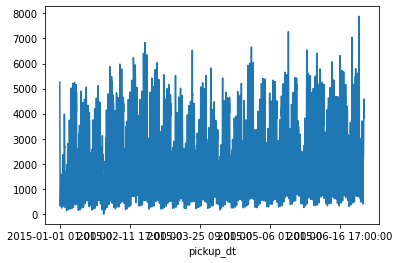

In [13]:
manhattan['pickups'].plot()

In [18]:
#donne le prix du jour d'apres car cela va etre le prix à prédire 
steps = -1
manhattan['actual'] = manhattan['pickups'].shift(steps)
manhattan.tail(3)

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,actual
pickup_dt,,,,,,,,,,,
2015-06-30 21:00:00,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,4452.0
2015-06-30 22:00:00,4452,5.0,10.0,76.0,64.0,1011.9,0.0,0.0,0.0,0.0,3828.0
2015-06-30 23:00:00,3828,7.0,10.0,75.0,65.0,1011.8,0.0,0.0,0.0,0.0,NaN


In [21]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0,1))
scaled_input = sc_in.fit_transform(manhattan[['pickups','temp']])
scaled_input= pd.DataFrame(scaled_input)
X = scaled_input
X.rename(columns={0:'pickups',1:'temp'}, inplace = True)
X

,pickups,temp
0,0.667005,0.321839
1,0.551186,0.321839
2,0.580617,0.321839
3,0.380946,0.310345
4,0.166561,0.298851
...,...,...
4338,0.581631,0.896552
4339,0.534061,0.896552
4340,0.547127,0.850575
4341,0.564760,0.850575


In [26]:
sc_out = MinMaxScaler(feature_range=(0,1))
scaler_output = sc_out.fit_transform(manhattan[['actual']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output
y.rename(columns={0:'pickups_hour_after'}, inplace = True)
y

,pickups_hour_after
0,0.551186
1,0.580617
2,0.380946
3,0.166561
4,0.085247
...,...
4338,0.534061
4339,0.547127
4340,0.564760
4341,0.485602


In [27]:
train_size = int(len(manhattan)*0.7)
test_size = int(len(manhattan)) - train_size

X_train, y_train = X[:train_size].dropna(), y[:train_size].dropna()
X_test, y_test = X[train_size:].dropna(), y[train_size:].dropna()
X_train

,pickups,temp
0,0.667005,0.321839
1,0.551186,0.321839
2,0.580617,0.321839
3,0.380946,0.310345
4,0.166561,0.298851
...,...,...
3035,0.289991,0.678161
3036,0.263352,0.724138
3037,0.283395,0.758621
3038,0.344539,0.816092


/Users/jerem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


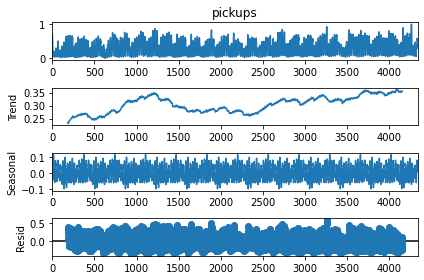

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(X['pickups'], model= 'add', freq=365)

fig = sd.plot()
fig.set_figheight(4)
plt.show()

In [49]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [50]:
test = y['pickups_hour_after'][:train_size].dropna()
test_adf(test,'pickups')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary pickups


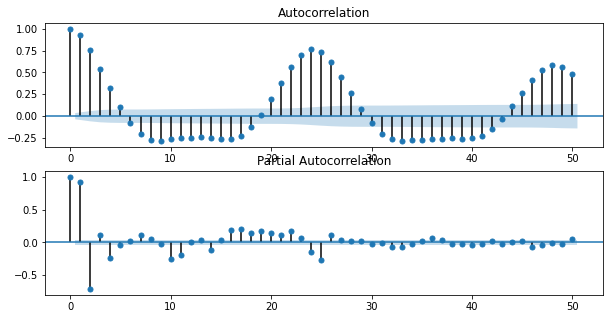

In [51]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(test, lags=50, ax=ax[1])
plt.show()

In [53]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
 exogenous= X_train,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9658.760, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9399.438, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9567.057, Time=1.84 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9660.602, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9401.438, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9658.789, Time=1.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9796.288, Time=3.78 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9655.646, Time=2.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9656.353, Time=3.92 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9657.566, Time=3.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9657.756, Time=3.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9653.580, Time=4.44 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-9967.000, Time=3.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9660.801, Time=1.85 sec
 ARIMA(1,1,1)(0,0,0

In [54]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3040
Model:               SARIMAX(1, 1, 2)   Log Likelihood                4989.500
Date:                Sat, 17 Oct 2020   AIC                          -9967.000
Time:                        14:21:57   BIC                          -9930.885
Sample:                             0   HQIC                         -9954.018
                               - 3040                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pickups        0.6321      0.149      4.232      0.000       0.339       0.925
temp           0.0666      0.037      1.811      0.070      -0.005       0.139
ar.L1          0.6248      0.150      4.170      0.000       0.331       0.918
ma.L1         -0.5184      0.014    -36.050      0.000      -0.547      -0.490
ma.L2         -0.4642      0.012    -39.197      0.000      -0.487      -0.441
sigma2         0.0023   3.88e-05     59.611      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                     1905.92   Jarque-Bera (JB):              2341.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.01
Prob(H) (two-sided):                  0.94   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(y_train, 
 exog=X_train,
 order=(1,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

In [188]:
#le nombre d'iteration est de 50 par default ce qui empeche le maximum likehood optimization de converger
#pour résoudre le problème de converger on augment le parametre maxiter de la methode fit
#ca diminue legerement notre erreur :  de 27.15 -> 27.14
results = model.fit(maxiter = 100)

In [177]:
results.mle_retvals

{'fopt': -1.6468296258958772,
 'gopt': array([ 1.69327663e-05, -7.50155493e-07,  3.08286952e-05, -1.34790179e-05,
        -1.10377107e-04, -4.96371477e-04]),
 'fcalls': 462,
 'warnflag': 0,
 'converged': True,
 'iterations': 51}

In [178]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps),exog=X_test)

In [179]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [180]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=X_test.index
predictions['actual'] = act['pickups_hour_after']
predictions.rename(columns={0:'Pred'}, inplace=True)
predictions

,Pred,actual
3040,0.543607,0.599899
3041,0.578579,0.676900
3042,0.604409,0.577572
3043,0.522686,0.617531
3044,0.537087,0.673855
...,...,...
4338,0.493193,0.534061
4339,0.462004,0.547127
4340,0.469399,0.564760
4341,0.480959,0.485602


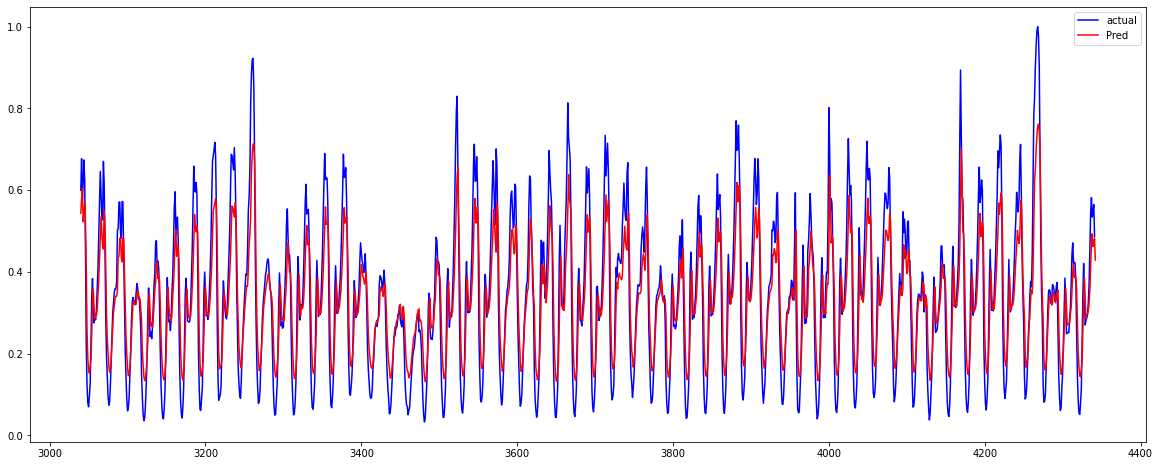

In [181]:
predictions['actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [182]:
forecast= results.forecast(steps=test_size, exog=X_test)

In [183]:
forecast= pd.DataFrame(forecast)
forecast.reset_index(drop=True, inplace=True)
forecast.index=X_test.index
forecast['actual'] =scaler_output.iloc[train_size:, 0]
forecast.rename(columns={0:'Forecast'}, inplace=True)

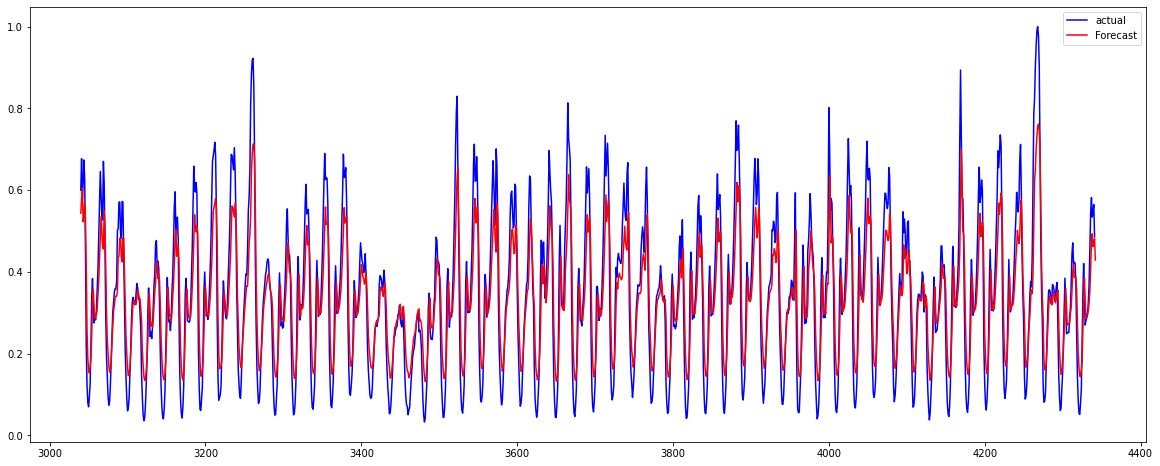

In [184]:
forecast['actual'].plot(figsize=(20,8), legend=True, color='blue')
forecast['Forecast'].plot(legend=True, color='red', figsize=(20,8))

In [185]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['actual']])

In [186]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [187]:
evaluating = smape_perso(trainPredict[:-1], testPredict[:-1])
evaluating

27.149035070867107